In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from tensorflow_probability.python.math.psd_kernels.internal import util
from typing import List

# Configure plot defaults
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["grid.color"] = "#666666"

In [2]:
np.random.seed(0)

# Multi-Fidelity GP using Two GPs using tensorflow

In this tutorial, we try to apply NARGP using tensorflow probability

Not entirely sure:

- Training. Need MC samples or just mean?
- Predicting. Need MC samples or just mean? (I think this one needs MC samples)
- Noise. Trainable or not? (I think depends on problem)


In [3]:
# example from https://adapt-python.github.io/adapt/examples/Multi_fidelity.html
def low_fidelity(Xs):
    ys = (1 - Xs**2) * np.sin(2 * 2 * np.pi * Xs) - Xs
    return ys


def high_fidelity(Xt):
    yt = (1 - Xt**2) * np.sin(2 * 2 * np.pi * Xt) - Xt - 1.5
    return yt

In [4]:
x_plot = np.linspace(0, 1, 200)[:, None]
y_plot_l = low_fidelity(x_plot)
y_plot_h = high_fidelity(x_plot)

x_train_l = x_plot
x_train_h = x_plot[:100]
y_train_l = low_fidelity(x_train_l) + 0.1 * np.random.randn(len(x_train_l))[:, None]
y_train_h = high_fidelity(x_train_h)

More HF training points than the LF training points.


In [5]:
y_train_h.shape, y_train_l.shape

((100, 1), (200, 1))

Text(0.5, 1.0, 'High and low fidelity Forrester functions')

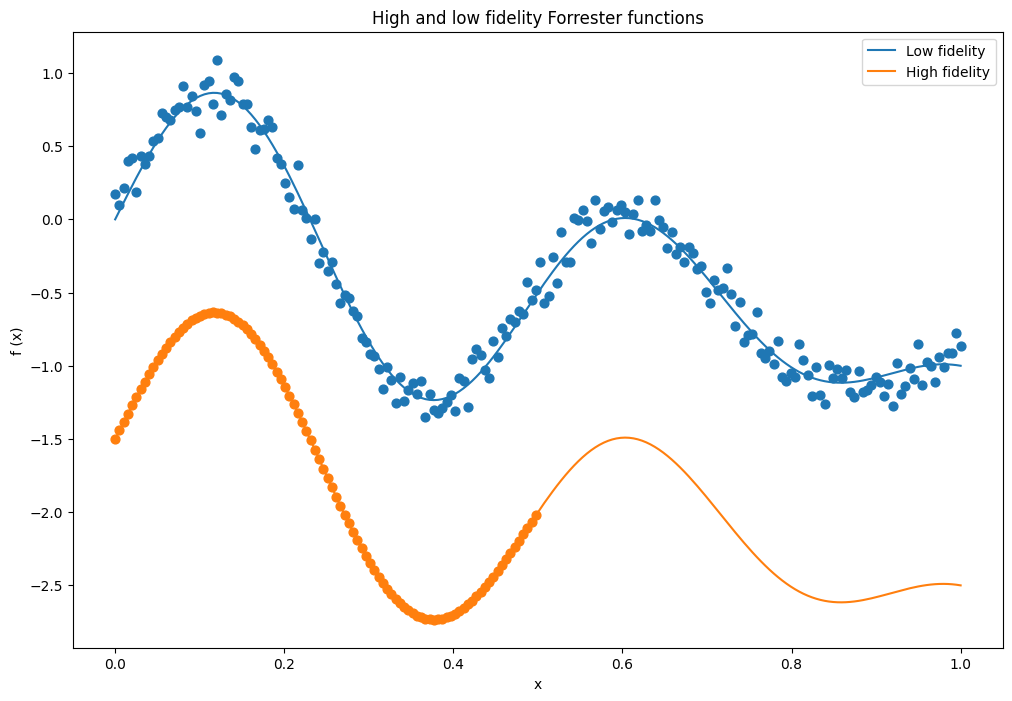

In [6]:
## Plot the original functions

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, "C0")
plt.plot(x_plot, y_plot_h, "C1")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["Low fidelity", "High fidelity"])
plt.title("High and low fidelity Forrester functions")

## Normalize with sample mean

Gaussian process will always use the zero mean if not specified.
It means the GP prediction will regress to the zero mean when there is no data.
Thus, this is essential to subtract the sample mean to make sure the GP prior is placed
at the center of the data **when we want to use GP to do extrapolation**.

Note that it is not so much an issue if we only want the interpolation values.


Normalize with the mean for each fidelity


In [7]:
# [LF]
y_train_l_mean = y_train_l.mean()
y_train_l_old = y_train_l
y_train_l = y_train_l - y_train_l_mean
# [HF]
y_train_h_mean = y_train_h.mean()
y_train_h_old = y_train_h
y_train_h = y_train_h - y_train_h_mean

## Multi-fidelity with Non-linear Autoregressive Model

We could define a new kernel class to incorporate two kernels


Here we build two GPs, while passing the 1st GP's output to the second GP.


In [8]:
class ActiveDimension(tfk.FeatureTransformed):
    def __init__(
        self,
        kernel,
        active_dim: List,
        validate_args=False,
        parameters=None,
        name="ActiveDim",
    ) -> None:
        self._transformation_fn = (
            lambda x, feature_ndims, param_expansion_ndims: tf.gather(
                x,
                active_dim,
                axis=-1,
            )
        )

        super(ActiveDimension, self).__init__(
            kernel=kernel,
            transformation_fn=self._transformation_fn,
            validate_args=validate_args,
            parameters=parameters,
            name=name,
        )

        # Keep the kernel so that we can get the batch shape
        self._kernel = kernel

    @property
    def batch_shape(self):
        return self._kernel.batch_shape

    def batch_shape_tensor(self):
        return self._kernel.batch_shape_tensor

In [9]:
n_input_dims = 1
n_output_dim = 1
base_dims_list = list(range(n_input_dims))
out_dims_list = list(range(n_input_dims, n_input_dims + n_output_dim))

In [10]:
def build_gp_lf(amplitude, length_scale, observation_noise_variance):
    """
    Low-fidelity:
    Defines the conditional dist. of GP outputs, given kernel parameters.

    X_LF -> GP_LF -> Y_LF

    """

    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)
    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=x_train_l,
        # jibancat: for this example, no need to open the noise
        observation_noise_variance=observation_noise_variance,
    )


def build_gp_nargp(
    scale_amplitude_0,  # HF
    scale_length_scale_0,  # HF
    interaction_amplitude_0,  # HF
    interaction_length_scale_0,  # HF
    bias_amplitude_0,  # HF
    bias_length_scale_0,  # HF
    linear_bias_amplitude_0,  # HF
    linear_slope_amplitude_0,  # HF
    linear_shift_0,
    amplitude_1,  # LF
    length_scale_1,  # LF
    observation_noise_variance_0,
    observation_noise_variance_1,
):
    """
    High-fidelity:
    Defines the conditional dist. of GP outputs, given kernel parameters.

    f_HF = \rho f_LF + \delta

      X_HF -> GP_LF -> f_LF
      X_HF -> GP_HF -> delta_HF
                  -> f_LF * rho + delta_HF
    """
    # HF kernel
    scale_kernel = ActiveDimension(
        tfk.ExponentiatedQuadratic(scale_amplitude_0, scale_length_scale_0),
        active_dim=out_dims_list,
    )
    scale_kernel += ActiveDimension(
        tfk.Linear(
            bias_amplitude=linear_bias_amplitude_0,
            slope_amplitude=linear_slope_amplitude_0,
            shift=linear_shift_0,
        ),
        active_dim=out_dims_list,
    )
    interaction_kernel = ActiveDimension(
        tfk.ExponentiatedQuadratic(interaction_amplitude_0, interaction_length_scale_0),
        active_dim=base_dims_list,
    )
    bias_kernel = ActiveDimension(
        tfk.ExponentiatedQuadratic(bias_amplitude_0, bias_length_scale_0),
        active_dim=base_dims_list,
    )
    # NARGP kernel
    kernel_h = interaction_kernel * scale_kernel + bias_kernel

    # LF kernel
    kernel_l1 = tfk.ExponentiatedQuadratic(amplitude_1, length_scale_1)
    ## Mean predictions from the LF GP
    gprm_l1 = tfd.GaussianProcessRegressionModel(
        kernel=kernel_l1,
        index_points=x_train_h,
        observation_index_points=x_train_l,
        observations=y_train_l[:, 0],
        observation_noise_variance=observation_noise_variance_1,
        predictive_noise_variance=0.0,
    )
    m1 = gprm_l1.mean()

    ## Index points for H include [X, mean from L1]
    index_points_h = tf.concat([x_train_h, m1[:, None]], axis=1)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel_h,
        index_points=index_points_h,
        # jibancat: for this example, no need to open the noise
        observation_noise_variance=observation_noise_variance_0,
    )


gp_joint_model_lf = tfd.JointDistributionNamed(
    {
        "amplitude": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "length_scale": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "observation_noise_variance": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "observations": build_gp_lf,
    }
)

gp_joint_model_hf = tfd.JointDistributionNamed(
    {
        "scale_amplitude_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "scale_length_scale_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "interaction_amplitude_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "interaction_length_scale_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "bias_amplitude_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "bias_length_scale_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "linear_bias_amplitude_0": tfd.LogNormal(
            loc=0.0, scale=np.float64(1.0)
        ),  # linear
        "linear_slope_amplitude_0": tfd.LogNormal(
            loc=0.0, scale=np.float64(1.0)
        ),  # linear
        "linear_shift_0": tfd.Normal(loc=0.0, scale=np.float64(1.0)),  # linear
        "amplitude_1": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "length_scale_1": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "observation_noise_variance_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "observation_noise_variance_1": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "observations": build_gp_nargp,
    }
)

In [11]:
# Test the batch shape
gp_joint_model_lf.batch_shape, gp_joint_model_hf.batch_shape

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
Instructions for updating:
`always_yield_multivariate_normal` is deprecated. This arg is now ignoredand will be removed after 2023-07-01. A `GaussianProcess` evaluated at asingle index point now always has event shape `[1]` (the previous behaviorfor `always_yield_multivariate_normal=True`). To reproduce the previous behavior of `always_yield_multivariate_normal=False`, squeeze the rightmost singleton dimension from the output of `mean`, `sample`, etc.


Instructions for updating:
`always_yield_multivariate_normal` is deprecated. This arg is now ignoredand will be removed after 2023-07-01. A `GaussianProcessRegressionModel`evaluated at a single index point now always has event shape `[1]` (theprevious behavior for `always_yield_multivariate_normal=True`). Toreproduce the previous behavior of`always_yield_multivariate_normal=False`, squeeze the rightmost singletondimension from the output of `mean`, `sample`, etc.


({'observation_noise_variance': TensorShape([]),
  'length_scale': TensorShape([]),
  'amplitude': TensorShape([]),
  'observations': TensorShape([])},
 {'scale_length_scale_0': TensorShape([]),
  'scale_amplitude_0': TensorShape([]),
  'observation_noise_variance_1': TensorShape([]),
  'observation_noise_variance_0': TensorShape([]),
  'linear_slope_amplitude_0': TensorShape([]),
  'linear_shift_0': TensorShape([]),
  'linear_bias_amplitude_0': TensorShape([]),
  'length_scale_1': TensorShape([]),
  'interaction_length_scale_0': TensorShape([]),
  'interaction_amplitude_0': TensorShape([]),
  'bias_length_scale_0': TensorShape([]),
  'bias_amplitude_0': TensorShape([]),
  'amplitude_1': TensorShape([]),
  'observations': TensorShape([])})

Set the learnable parameters and train based on the maximum marginal likelihoods of two GPs.


In [12]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.
# jibancat: the scale parameter no needs to be positive,
# but I guess it's okay to constrain it to be positive so the delta would
# compensate the sign difference.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

identity = tfb.Identity()


scale_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="scale_amplitude_0",
    dtype=np.float64,
)
scale_length_scale_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="scale_length_scale_0",
    dtype=np.float64,
)
interaction_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="interaction_amplitude_0",
    dtype=np.float64,
)
interaction_length_scale_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="interaction_length_scale_0",
    dtype=np.float64,
)
bias_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="bias_amplitude_0",
    dtype=np.float64,
)
bias_length_scale_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="bias_length_scale_0",
    dtype=np.float64,
)

# Linear kernel
linear_bias_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="linear_bias_amplitude_0",
    dtype=np.float64,
)
linear_slope_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="linear_slope_amplitude_0",
    dtype=np.float64,
)
linear_shift_var_0 = tfp.util.TransformedVariable(
    initial_value=np.float64(0.0),
    bijector=identity,
    name="linear_shift_0",
    dtype=np.float64,
)

# Noise
observation_noise_variance_var_0 = tfp.util.TransformedVariable(
    initial_value=1e-5,
    bijector=constrain_positive,
    name="observation_noise_variance_var_0",
    dtype=np.float64,
)

# L1 parameters
amplitude_var_1 = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=constrain_positive, name="amplitude_1", dtype=np.float64
)

length_scale_var_1 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="length_scale_1",
    dtype=np.float64,
)

observation_noise_variance_var_1 = tfp.util.TransformedVariable(
    initial_value=1e-5,
    bijector=constrain_positive,
    name="observation_noise_variance_var_1",
    dtype=np.float64,
)


# [NARGP]
trainable_variables = [
    v.trainable_variables[0]
    for v in [
        scale_amplitude_var_0,
        scale_length_scale_var_0,
        interaction_amplitude_var_0,
        interaction_length_scale_var_0,
        bias_amplitude_var_0,
        bias_length_scale_var_0,
        observation_noise_variance_var_0,
        linear_bias_amplitude_var_0,
        linear_slope_amplitude_var_0,
        linear_shift_var_0,
    ]
]

# [LF only]
trainable_variables_LF = [
    v.trainable_variables[0]
    for v in [
        amplitude_var_1,
        length_scale_var_1,
        observation_noise_variance_var_1,
    ]
]

Let's test if we can compute the log prob


In [13]:
x_l = gp_joint_model_lf.sample()
lp_l = gp_joint_model_lf.log_prob(x_l)

print("sampled {}".format(x_l))
print("log_prob of sample: {}".format(lp_l))

sampled {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=3.5160436061628344>, 'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=0.997729323551399>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=1.722544320970296>, 'observations': <tf.Tensor: shape=(200,), dtype=float64, numpy=
array([ 0.26029675, -1.93832684,  0.26801873,  2.60262288, -0.93981774,
       -0.25313423,  1.90325161,  0.23166655, -0.42563703,  0.18949794,
        1.18220259,  0.61118985, -0.62064799,  0.76061054, -0.58585248,
        3.33647535,  0.02960521,  1.36367386, -0.12441221, -0.68076391,
        3.62150948, -0.35771224,  4.52170615,  2.68189989,  1.39346137,
        0.45289147,  1.74791058,  0.13373238,  1.43852992,  2.03704349,
        3.27173456,  0.93898467, -0.71517891,  0.42288364,  0.99822393,
       -2.59670047,  2.26844523,  0.97103682,  3.45983239,  2.66049256,
        2.22191532,  0.46858563,  2.63190649, -0.90280639,  2.5986192 ,
       -0.65134557,  2.1804262

In [14]:
x_h = gp_joint_model_hf.sample()
lp_h = gp_joint_model_hf.log_prob(x_h)

print("sampled {}".format(x_h))
print("log_prob of sample: {}".format(lp_h))

sampled {'scale_length_scale_0': <tf.Tensor: shape=(), dtype=float64, numpy=0.6303196322812726>, 'scale_amplitude_0': <tf.Tensor: shape=(), dtype=float64, numpy=0.7571656958716698>, 'observation_noise_variance_1': <tf.Tensor: shape=(), dtype=float64, numpy=1.369641780548082>, 'observation_noise_variance_0': <tf.Tensor: shape=(), dtype=float64, numpy=1.8786969839474676>, 'linear_slope_amplitude_0': <tf.Tensor: shape=(), dtype=float64, numpy=0.5512519825743109>, 'linear_shift_0': <tf.Tensor: shape=(), dtype=float64, numpy=0.4803341996643655>, 'linear_bias_amplitude_0': <tf.Tensor: shape=(), dtype=float64, numpy=1.7182960057216135>, 'length_scale_1': <tf.Tensor: shape=(), dtype=float64, numpy=1.242723581368799>, 'interaction_length_scale_0': <tf.Tensor: shape=(), dtype=float64, numpy=1.4556356293788266>, 'interaction_amplitude_0': <tf.Tensor: shape=(), dtype=float64, numpy=0.310250760400063>, 'bias_length_scale_0': <tf.Tensor: shape=(), dtype=float64, numpy=0.8347493311793558>, 'bias_ampl

To condition the model on our observed data, we'll define a `target_log_prob` function, which takes the (still to be inferred) kernel hyperparameters.

We will combine the log likelihoods from both GP_LF and GP_HF to be one joint likelihood.


In [15]:
def target_log_prob_LF(
    amplitude_1,
    length_scale_1,
    observation_noise_variance_1,
):
    """
    Loglike(LF)
    """

    log_prob_lf = gp_joint_model_lf.log_prob(
        {
            "amplitude": amplitude_1,
            "length_scale": length_scale_1,
            "observation_noise_variance": observation_noise_variance_1,
            "observations": y_train_l[:, 0],
        }
    )

    return log_prob_lf

In [16]:
def target_log_prob(
    scale_amplitude_0,  # HF
    scale_length_scale_0,  # HF
    interaction_amplitude_0,  # HF
    interaction_length_scale_0,  # HF
    bias_amplitude_0,  # HF
    bias_length_scale_0,  # HF
    observation_noise_variance_0,
    linear_bias_amplitude_0,
    linear_slope_amplitude_0,
    linear_shift_0,
    amplitude_1,
    length_scale_1,
    observation_noise_variance_1,
):
    """
    Loglike(LF) + Loglike(HF)
    """

    log_prob_hf = gp_joint_model_hf.log_prob(
        {
            "scale_amplitude_0": scale_amplitude_0,
            "scale_length_scale_0": scale_length_scale_0,
            "interaction_amplitude_0": interaction_amplitude_0,
            "interaction_length_scale_0": interaction_length_scale_0,
            "bias_amplitude_0": bias_amplitude_0,
            "bias_length_scale_0": bias_length_scale_0,
            "linear_bias_amplitude_0": linear_bias_amplitude_0,
            "linear_slope_amplitude_0": linear_slope_amplitude_0,
            "linear_shift_0": linear_shift_0,
            "amplitude_1": amplitude_1,
            "length_scale_1": length_scale_1,
            "observation_noise_variance_0": observation_noise_variance_0,
            "observation_noise_variance_1": observation_noise_variance_1,
            "observations": y_train_h[:, 0],
        }
    )

    return log_prob_hf

Toy example only works with fixed noise = 0.


In [17]:
# Now we optimize the model parameters.
num_iters = 2000
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2)

# Fix the noise will increase the stability of the hyperkernel parameters training
fixed_noise = 1e-5


# [Low-fidelity] Fixed noise
@tf.function(autograph=False, jit_compile=False)
def train_model_LFonly_fixed():
    with tf.GradientTape() as tape:
        loss = -target_log_prob_LF(
            amplitude_1=amplitude_var_1,
            length_scale_1=length_scale_var_1,
            observation_noise_variance_1=fixed_noise,
        )
    grads = tape.gradient(loss, trainable_variables_LF)
    optimizer.apply_gradients(zip(grads, trainable_variables_LF))
    return loss


# [LF only] Fixed noise
lls_noise_lfonly_fixed = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model_LFonly_fixed()
    lls_noise_lfonly_fixed[i] = loss

num_iters = 10000
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-3)


# [Low-fidelity] Relaxed noise
@tf.function(autograph=False, jit_compile=False)
def train_model_LFonly():
    with tf.GradientTape() as tape:
        loss = -target_log_prob_LF(
            amplitude_1=amplitude_var_1,
            length_scale_1=length_scale_var_1,
            observation_noise_variance_1=observation_noise_variance_var_1,
        )
    grads = tape.gradient(loss, trainable_variables_LF)
    optimizer.apply_gradients(zip(grads, trainable_variables_LF))
    return loss


# [LF only] Relaxed noise
lls_noise_lfonly = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model_LFonly()
    lls_noise_lfonly[i] = loss

# [Fix Low-fidelity node] Perdikaris et al.
# So the likelihood from the LF node is fixed.
## L1
fixed_noise_L1 = observation_noise_variance_var_1._value().numpy()
fixed_amplitude_1 = amplitude_var_1._value().numpy()
fixed_length_scale_1 = length_scale_var_1._value().numpy()


# Now we optimize the model parameters.
num_iters = 5000
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2)


# Fixed noise
@tf.function(autograph=False, jit_compile=False)
def train_model_fixed_noise():
    with tf.GradientTape() as tape:
        loss = -target_log_prob(
            scale_amplitude_0=scale_amplitude_var_0,
            scale_length_scale_0=scale_length_scale_var_0,
            interaction_amplitude_0=interaction_amplitude_var_0,
            interaction_length_scale_0=interaction_length_scale_var_0,
            bias_amplitude_0=bias_amplitude_var_0,
            bias_length_scale_0=bias_length_scale_var_0,
            linear_bias_amplitude_0=linear_bias_amplitude_var_0,
            linear_slope_amplitude_0=linear_slope_amplitude_var_0,
            linear_shift_0=linear_shift_var_0,
            amplitude_1=fixed_amplitude_1,
            length_scale_1=fixed_length_scale_1,
            observation_noise_variance_0=fixed_noise,
            observation_noise_variance_1=fixed_noise_L1,
        )
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss


# Fixed noise
lls_noise_fixed = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model_fixed_noise()
    lls_noise_fixed[i] = loss

# Now we optimize the model parameters.
num_iters = 7500
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)


# Not fix noise
# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
    with tf.GradientTape() as tape:
        loss = -target_log_prob(
            scale_amplitude_0=scale_amplitude_var_0,
            scale_length_scale_0=scale_length_scale_var_0,
            interaction_amplitude_0=interaction_amplitude_var_0,
            interaction_length_scale_0=interaction_length_scale_var_0,
            bias_amplitude_0=bias_amplitude_var_0,
            bias_length_scale_0=bias_length_scale_var_0,
            linear_bias_amplitude_0=linear_bias_amplitude_var_0,
            linear_slope_amplitude_0=linear_slope_amplitude_var_0,
            linear_shift_0=linear_shift_var_0,
            amplitude_1=fixed_amplitude_1,
            length_scale_1=fixed_length_scale_1,
            # In this example, the H node there's no noise
            observation_noise_variance_0=observation_noise_variance_var_0,
            observation_noise_variance_1=fixed_noise_L1,
        )
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss


# Relaxed noise
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model()
    lls_[i] = loss


print("Trained parameters:")
print("LF amplitude: {}".format(amplitude_var_1._value().numpy()))
print("LF length_scale: {}".format(length_scale_var_1._value().numpy()))
print("HF scale amplitude: {}".format(scale_amplitude_var_0._value().numpy()))
print("HF scale length_scale: {}".format(scale_length_scale_var_0._value().numpy()))
print(
    "HF interaction amplitude: {}".format(interaction_amplitude_var_0._value().numpy())
)
print(
    "HF interaction length_scale: {}".format(
        interaction_length_scale_var_0._value().numpy()
    )
)
print("HF bias amplitude: {}".format(bias_amplitude_var_0._value().numpy()))
print("HF bias length_scale: {}".format(bias_length_scale_var_0._value().numpy()))

print("Linear kernel:")
print("----")
print(
    "HF linear bias amplitude: {}".format(linear_bias_amplitude_var_0._value().numpy())
)
print(
    "HF linear slope amplitude: {}".format(
        linear_slope_amplitude_var_0._value().numpy()
    )
)
print("HF linear shift: {}".format(linear_shift_var_0._value().numpy()))

print("Noise:")
print("----")
print(
    "HF observation_noise_variance: {}".format(
        observation_noise_variance_var_0._value().numpy()
    )
)
print(
    "LF observation_noise_variance: {}".format(
        observation_noise_variance_var_1._value().numpy()
    )
)

2023-08-12 20:14:52.056834: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Trained parameters:
LF amplitude: 0.8195028395454929
LF length_scale: 0.15861293260540052
HF scale amplitude: 0.17558009811626996
HF scale length_scale: 2.9014479570222096
HF interaction amplitude: 0.4771365475641044
HF interaction length_scale: 0.5426244823963042
HF bias amplitude: 0.15466128570313373
HF bias length_scale: 0.23665976925227727
Linear kernel:
----
HF linear bias amplitude: 0.22688658541687895
HF linear slope amplitude: 1.6209500701917843
HF linear shift: 0.3686534233341038
Noise:
----
HF observation_noise_variance: 4.351681760641605e-07
LF observation_noise_variance: 0.009580171423811006


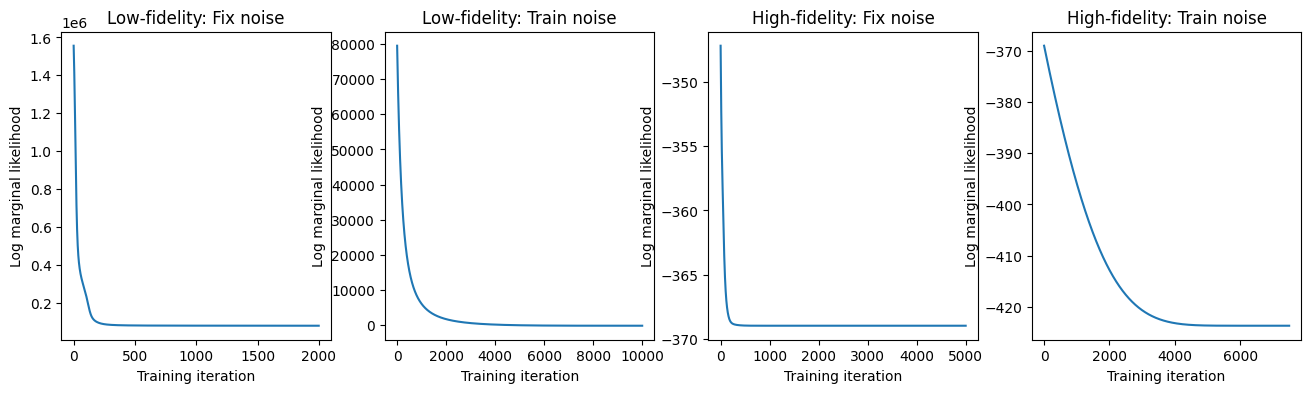

In [18]:
# Plot the loss evolution
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].plot(lls_noise_lfonly_fixed)
ax[0].set_title("Low-fidelity: Fix noise")
ax[0].set_xlabel("Training iteration")
ax[0].set_ylabel("Log marginal likelihood")

ax[1].plot(lls_noise_lfonly)
ax[1].set_title("Low-fidelity: Train noise")
ax[1].set_xlabel("Training iteration")
ax[1].set_ylabel("Log marginal likelihood")

ax[2].plot(lls_noise_fixed)
ax[2].set_title("High-fidelity: Fix noise")
ax[2].set_xlabel("Training iteration")
ax[2].set_ylabel("Log marginal likelihood")

ax[3].plot(lls_)
ax[3].set_title("High-fidelity: Train noise")
ax[3].set_xlabel("Training iteration")
ax[3].set_ylabel("Log marginal likelihood")

plt.show()

In [19]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(0, 1, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]


# HF kernel
optimized_scale_kernel = ActiveDimension(
    tfk.ExponentiatedQuadratic(scale_amplitude_var_0, scale_length_scale_var_0),
    active_dim=out_dims_list,
)
optimized_scale_kernel += ActiveDimension(
    tfk.Linear(
        bias_amplitude=linear_bias_amplitude_var_0,
        slope_amplitude=linear_slope_amplitude_var_0,
        shift=linear_shift_var_0,
    ),
    active_dim=out_dims_list,
)

optimized_interaction_kernel = ActiveDimension(
    tfk.ExponentiatedQuadratic(
        interaction_amplitude_var_0, interaction_length_scale_var_0
    ),
    active_dim=base_dims_list,
)
optimized_bias_kernel = ActiveDimension(
    tfk.ExponentiatedQuadratic(bias_amplitude_var_0, bias_length_scale_var_0),
    active_dim=base_dims_list,
)
# NARGP kernel
optimized_kernel_h = (
    optimized_interaction_kernel * optimized_scale_kernel + optimized_bias_kernel
)


# LF kernel
optimized_kernel_1 = tfk.ExponentiatedQuadratic(amplitude_var_1, length_scale_var_1)

## Passing information from low-fidelity node
# L1 index points
index_optimized_gprm_l1 = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=x_train_h,
    observation_index_points=x_train_l,
    observations=y_train_l[:, 0],
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)
# L1 predictive points
optimized_gprm_l1 = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=predictive_index_points_,
    observation_index_points=x_train_l,
    observations=y_train_l[:, 0],
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)

In [20]:
## Combine information
## Using Irene Ji's full covariance method
num_samples = 200
ntest = predictive_index_points_.shape[0]

index_m1 = index_optimized_gprm_l1.sample(num_samples)
m1 = optimized_gprm_l1.sample(num_samples)

tmp_m = np.zeros((num_samples, ntest))
tmp_v = np.zeros((num_samples, ntest))
tmp_sample = np.zeros((num_samples, ntest))
# This way you also account for the uncertainty from L1 node
for j in range(num_samples):
    index_points_h = tf.concat([x_train_h, index_m1[j, :][:, None]], axis=1)
    predictive_index_points_h = tf.concat(
        [predictive_index_points_, m1[j, :][:, None]], axis=1
    )

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    nargp_gprm = tfd.GaussianProcessRegressionModel(
        kernel=optimized_kernel_h,
        index_points=predictive_index_points_h,
        observation_index_points=index_points_h,
        observations=y_train_h[:, 0],
        observation_noise_variance=observation_noise_variance_var_0,
        predictive_noise_variance=np.float64(0.0),
    )

    tmp_m[j, :] = nargp_gprm.mean().numpy()
    tmp_v[j, :] = nargp_gprm.variance().numpy()
    tmp_sample[j, :] = nargp_gprm.sample().numpy()

mu_final = np.mean(tmp_m, axis=0)
v_final = np.mean(tmp_v, axis=0) + np.var(tmp_m, axis=0)
y_pred = mu_final[:, None]
var_pred = np.abs(v_final[:, None])

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
# num_samples = 500
# samples = nargp_gprm.sample(num_samples)

# # HF only
# h_gprm = tfd.GaussianProcessRegressionModel(
#     kernel=optimized_kernel_h,
#     index_points=predictive_index_points_,
#     observation_index_points=x_train_h,
#     observations=y_train_h[:, 0],
#     observation_noise_variance=observation_noise_variance_var_0,
#     predictive_noise_variance=np.float64(0.0),
# )

# h_samples = h_gprm.sample(num_samples)

# LF only
l1_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=predictive_index_points_,
    observation_index_points=x_train_l,
    observations=y_train_l[:, 0],
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)

l1_samples = l1_gprm.sample(num_samples)

/var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_75379/459058000.py:46: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


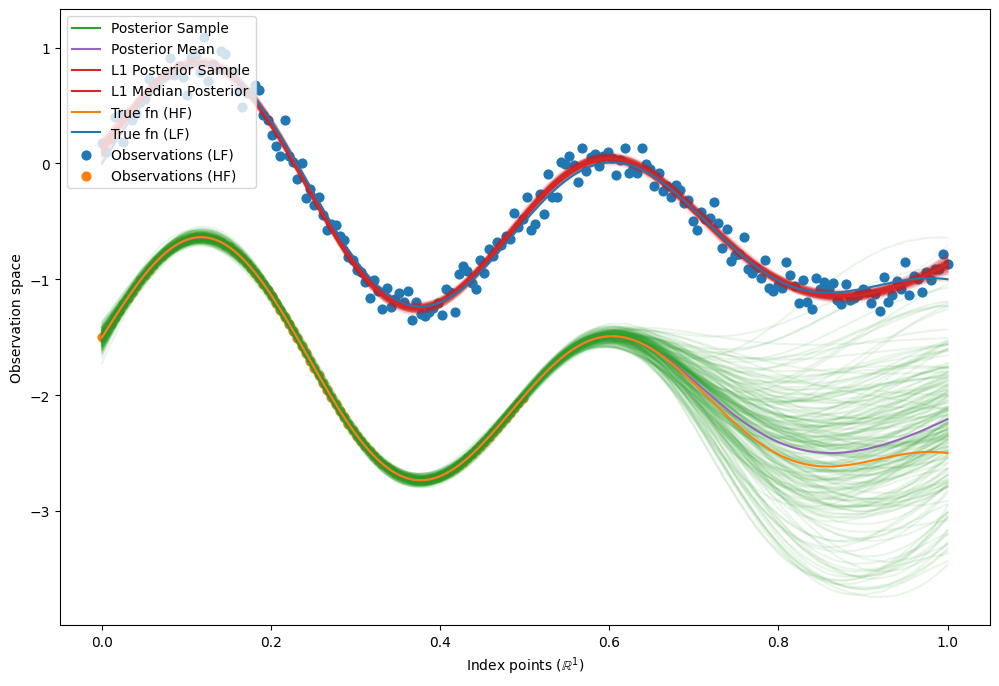

In [21]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 8))

# NARGP
for i in range(num_samples):
    plt.plot(
        predictive_index_points_,
        tmp_sample[i, :] + y_train_h_mean,
        c="C2",
        alpha=0.1,
        label="Posterior Sample" if i == 0 else None,
    )
# Posterior mean - the uncertainty passed using Monte Carlo sampling
plt.plot(
    predictive_index_points_,
    y_pred + y_train_h_mean,
    c="C4",
    label="Posterior Mean",
)

# HF
for i in range(num_samples):
    plt.plot(
        predictive_index_points_,
        l1_samples[i, :] + y_train_l_mean,
        c="C3",
        alpha=0.05,
        label="L1 Posterior Sample" if i == 0 else None,
    )

plt.plot(
    predictive_index_points_,
    np.median(l1_samples, axis=0) + y_train_l_mean,
    c="C3",
    label="L1 Median Posterior",
)

plt.plot(x_plot, y_plot_h, label="True fn (HF)", color="C1")
plt.plot(x_plot, y_plot_l, label="True fn (LF)", color="C0")

plt.scatter(x_train_l, y_train_l_old, color="C0", s=40, label="Observations (LF)")
plt.scatter(x_train_h, y_train_h_old, color="C1", s=40, label="Observations (HF)")


leg = plt.legend(loc="upper left")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

If you only train on HF data:


In [22]:
def build_gp(amplitude, length_scale, observation_noise_variance):
    """Defines the conditional dist. of GP outputs, given kernel parameters."""

    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)
    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=x_train_h,
        observation_noise_variance=observation_noise_variance,
    )


gp_joint_model = tfd.JointDistributionNamed(
    {
        "amplitude": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "length_scale": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "observation_noise_variance": tfd.LogNormal(loc=0.0, scale=np.float64(0.025)),
        "observations": build_gp,
    }
)

# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=constrain_positive, name="amplitude", dtype=np.float64
)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="length_scale",
    dtype=np.float64,
)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="observation_noise_variance_var",
    dtype=np.float64,
)

trainable_variables_hf_only = [
    v.trainable_variables[0]
    for v in [amplitude_var, length_scale_var, observation_noise_variance_var]
]


def target_log_prob_hf_only(amplitude, length_scale, observation_noise_variance):
    return gp_joint_model.log_prob(
        {
            "amplitude": amplitude,
            "length_scale": length_scale,
            "observation_noise_variance": observation_noise_variance,
            "observations": y_train_h[:, 0],
        }
    )


# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=0.01)


# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
    with tf.GradientTape() as tape:
        loss = -target_log_prob_hf_only(
            amplitude_var, length_scale_var, observation_noise_variance_var
        )
    grads = tape.gradient(loss, trainable_variables_hf_only)
    optimizer.apply_gradients(zip(grads, trainable_variables_hf_only))
    return loss


# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model()
    lls_[i] = loss


# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.

# HF only kernel
optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)

h_only_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=x_train_h,
    observations=y_train_h[:, 0],
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=np.float64(0.0),
)

h_only_samples = h_only_gprm.sample(num_samples)

Mean absolute error, a metric used in https://adapt-python.github.io/adapt/examples/Multi_fidelity.html


In [23]:
MAE = np.mean(np.abs((y_pred + y_train_h_mean) - y_plot_h))

/var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_75379/2601353123.py:51: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


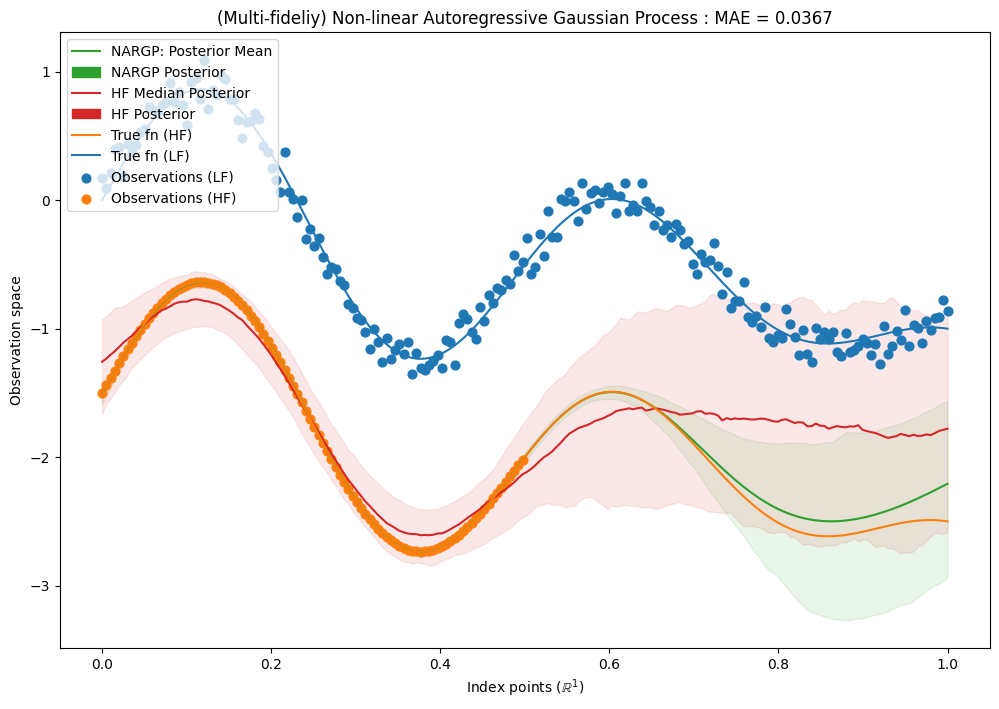

In [24]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 8))

lower, median, upper = np.quantile(tmp_sample, [0.1, 0.5, 0.9], axis=0)

# NARGP
plt.plot(
    predictive_index_points_,
    y_pred + y_train_h_mean,
    c="C2",
    label="NARGP: Posterior Mean",
)
plt.fill_between(
    predictive_index_points_[:, 0],
    lower + y_train_h_mean,
    upper + y_train_h_mean,
    color="C2",
    alpha=0.1,
    label="NARGP Posterior",
)


lower_hf, median_hf, upper_hf = np.quantile(
    h_only_samples.numpy(), [0.1, 0.5, 0.9], axis=0
)

# HF
plt.plot(
    predictive_index_points_,
    median_hf + y_train_h_mean,
    c="C3",
    label="HF Median Posterior",
)
plt.fill_between(
    predictive_index_points_[:, 0],
    lower_hf + y_train_h_mean,
    upper_hf + y_train_h_mean,
    color="C3",
    alpha=0.1,
    label="HF Posterior",
)

plt.plot(x_plot, y_plot_h, label="True fn (HF)", color="C1")
plt.plot(x_plot, y_plot_l, label="True fn (LF)", color="C0")

plt.scatter(x_train_l, y_train_l_old, color="C0", s=40, label="Observations (LF)")
plt.scatter(x_train_h, y_train_h_old, color="C1", s=40, label="Observations (HF)")


leg = plt.legend(loc="upper left")
for lh in leg.legendHandles:
    lh.set_alpha(1)

plt.title(
    "(Multi-fideliy) Non-linear Autoregressive Gaussian Process : MAE = {:.3g}".format(
        MAE
    )
)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()